<a href="https://colab.research.google.com/github/mortezakhorsandnikoo/Thermal-energy-analysis-of-residential-building-based-on-linear-regression-model/blob/main/cat_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torchvision 
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import glob
import os
import matplotlib.pyplot as plt
from torch.utils import data
from tqdm import tqdm

In [2]:
sz=224
batch_size=16

In [3]:
# Load the Drive helper and mount
from google.colab import drive


In [4]:
path="/content/drive/MyDrive/dev/"

In [5]:
os.listdir("/content/drive/MyDrive/dev/")

['train', 'valid']

In [6]:
train_dir=f"{path}train"

In [7]:
valid_dir=f"{path}valid"

In [8]:
trnsf= transforms.Compose([
    transforms.Resize((sz , sz)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,.5],[0.229 , 0.224 , 0.255] ) ])

In [9]:
train_ds=datasets.ImageFolder(train_dir, transform=trnsf)

In [10]:
valid_ds=datasets.ImageFolder(valid_dir, transform=trnsf)

In [11]:
len(train_ds.imgs)

2010

In [12]:
train_ds.class_to_idx

{'cat': 0, 'dog': 1}

In [13]:
train_ds.imgs[:10]

[('/content/drive/MyDrive/dev/train/cat/0.jpg', 0),
 ('/content/drive/MyDrive/dev/train/cat/1.jpg', 0),
 ('/content/drive/MyDrive/dev/train/cat/10.jpg', 0),
 ('/content/drive/MyDrive/dev/train/cat/100.jpg', 0),
 ('/content/drive/MyDrive/dev/train/cat/101.jpg', 0),
 ('/content/drive/MyDrive/dev/train/cat/102.jpg', 0),
 ('/content/drive/MyDrive/dev/train/cat/103.jpg', 0),
 ('/content/drive/MyDrive/dev/train/cat/104.jpg', 0),
 ('/content/drive/MyDrive/dev/train/cat/105.jpg', 0),
 ('/content/drive/MyDrive/dev/train/cat/106.jpg', 0)]

In [14]:
trn_fnames=glob.glob(f"{train_dir}/*/*.jpg")
                     
trn_fnames[:8]       

['/content/drive/MyDrive/dev/train/dog/100.jpg',
 '/content/drive/MyDrive/dev/train/dog/10.jpg',
 '/content/drive/MyDrive/dev/train/dog/0.jpg',
 '/content/drive/MyDrive/dev/train/dog/1.jpg',
 '/content/drive/MyDrive/dev/train/dog/101.jpg',
 '/content/drive/MyDrive/dev/train/dog/102.jpg',
 '/content/drive/MyDrive/dev/train/dog/103.jpg',
 '/content/drive/MyDrive/dev/train/dog/104.jpg']

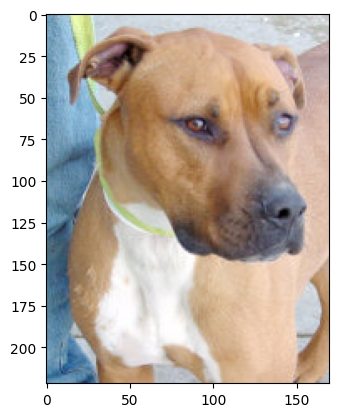

In [15]:
img=plt.imread(trn_fnames[8])
plt.imshow(img)  

In [16]:
#dataloaders
train_dl=data.DataLoader(train_ds , batch_size= batch_size , shuffle= True )

In [17]:
valid_dl=data.DataLoader(valid_ds , batch_size= batch_size , shuffle= True )

In [18]:
inputs , targets=next(iter(train_dl))




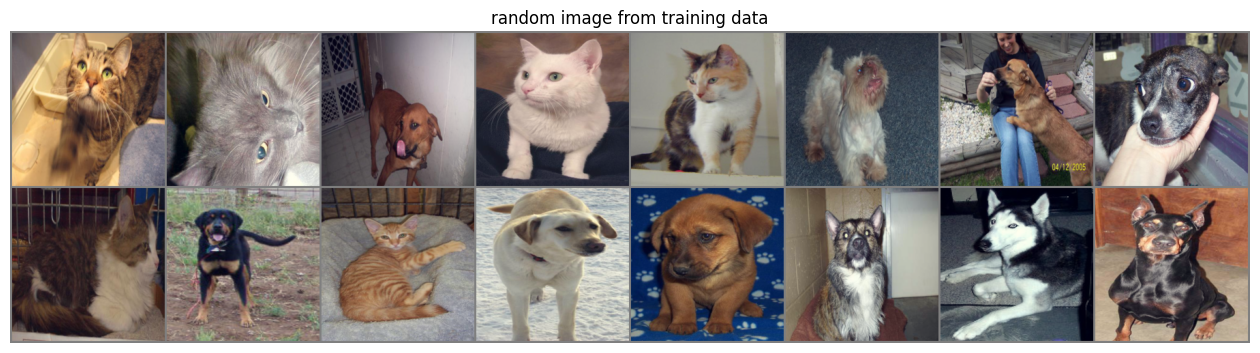

In [19]:
out=torchvision.utils.make_grid(inputs , padding=3)
title="random image from training data"
inp = out.numpy().transpose((1, 2, 0))
mean = np.array([0.5, 0.5, 0.5])
std  = np.array([0.229, 0.224, 0.225])
inp = std * inp + mean
inp = np.clip(inp, 0, 1)
plt.figure(figsize=(16,12))
plt.imshow(inp)
plt.axis('off')
if title is not None:
        plt.title(title)

In [39]:
from torch.nn.modules.batchnorm import BatchNorm2d
class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN , self).__init__()
    self.conv1= nn.Sequential(
        nn.Conv2d(3,16 , kernel_size= 5 , padding=2),  #3:dimension , 16 kernels
        nn.BatchNorm2d(16),
        nn.ReLU() )

    self.conv2= nn.Sequential(
        nn.Conv2d(16, 32, kernel_size= 5 , padding="same"),
        nn.BatchNorm2d(32),
        nn.ReLU() )
    
    self.conv3=nn.Sequential(
        nn.Conv2d(32,64 , kernel_size= 5 , padding="same"),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2))
    
    self.conv4= nn.Sequential(
        nn.Conv2d(64,112, kernel_size=5, padding="same"),
        nn.BatchNorm2d(112),
        nn.ReLU()  )
    
    self.conv5= nn.Sequential(
        nn.Conv2d(112, 224, kernel_size=5 , padding="same"),
        nn.BatchNorm2d(224),
        nn.ReLU(),
        nn.MaxPool2d(2))
    
    self.conv6=nn.Sequential(
        nn.Conv2d(224 , 512 , kernel_size = 5 , padding="same"),
        nn.BatchNorm2d(512),
        nn.ReLU())
    
    self.conv7=nn.Sequential(
        nn.Conv2d(512 , 720 , kernel_size=5 , padding= "same"),
        nn.BatchNorm2d(720),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    self.dense=nn.Linear(28*28*720, 2)
    
  def forward (self , X):
    out=self.conv1(X)
    out=self.conv2(out)
    out=self.conv3(out)
    out=self.conv4(out)
    out=self.conv5(out)
    out=self.conv6(out)
    out=self.conv7(out)
    out=out.view(out.size(0), -1)
    out=self.dense(out)
    return out


    


In [40]:
model=SimpleCNN()
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=model.to(device)


In [41]:
#loss_function
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters() , lr= 0.001 )

In [43]:
#train
num_epochs=10
losess=[]
for epoch in range(num_epochs):
  for i , (inputs, targets) in enumerate(train_dl):
    inputs=inputs.to(device)
    targets=targets.to(device)
    #forward pass
    outputs=model(inputs)

    #loss
    loss=criterion(outputs , targets)
    losess.append(loss.item())

    #backwards
    optimizer.zero_grad()
    loss.backward()

    #update parameters
    optimizer.step()

    #report
    if(i+1)%50==0:
      print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_ds) // batch_size, loss.item()))
      



Epoch [ 1/10], Step [ 50/125], Loss: 8.4269
Epoch [ 1/10], Step [100/125], Loss: 65.4458
Epoch [ 2/10], Step [ 50/125], Loss: 1.3446
Epoch [ 2/10], Step [100/125], Loss: 2.0813
Epoch [ 3/10], Step [ 50/125], Loss: 38.5497
Epoch [ 3/10], Step [100/125], Loss: 5.2496
Epoch [ 4/10], Step [ 50/125], Loss: 2.9437
Epoch [ 4/10], Step [100/125], Loss: 4.5231
Epoch [ 5/10], Step [ 50/125], Loss: 8.1285
Epoch [ 5/10], Step [100/125], Loss: 8.1421
Epoch [ 6/10], Step [ 50/125], Loss: 0.5275
Epoch [ 6/10], Step [100/125], Loss: 0.5068
Epoch [ 7/10], Step [ 50/125], Loss: 0.6561
Epoch [ 7/10], Step [100/125], Loss: 0.7419
Epoch [ 8/10], Step [ 50/125], Loss: 3.0427
Epoch [ 8/10], Step [100/125], Loss: 3.2363
Epoch [ 9/10], Step [ 50/125], Loss: 0.6421
Epoch [ 9/10], Step [100/125], Loss: 0.6084
Epoch [10/10], Step [ 50/125], Loss: 0.5944
Epoch [10/10], Step [100/125], Loss: 2.9306


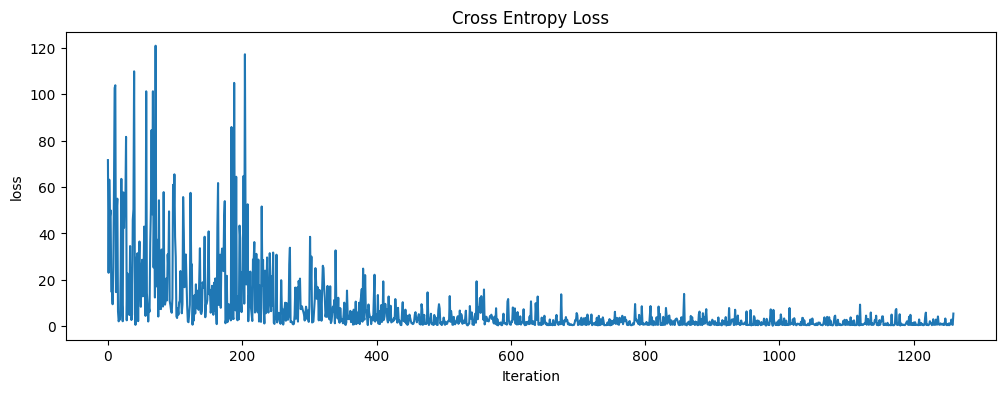

In [44]:
plt.figure(figsize=(12, 4))
plt.plot(losess)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss')
plt.show()

In [45]:
def evaluate_model(model, dataloader, device):
    model.eval()               # for batch normalization layers
    corrects = 0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()
    
    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))

In [46]:
evaluate_model(model, valid_dl, device)

accuracy: 56.72


In [47]:
evaluate_model(model, train_dl, device)

accuracy: 62.89


In [48]:
def visualize_model(model, dataloader, device, num_images=6):
    """ Visulaize the prediction of the model on a bunch of random data.
    """
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10., 8.))
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(dataloader.dataset.classes[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    return

In [49]:
def imshow(inp, title=None):
    """Imshow for Tensor.
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)

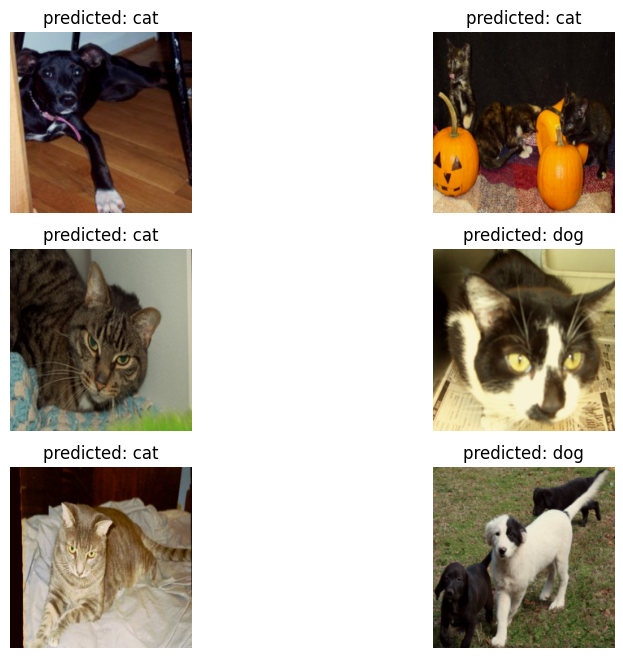

In [53]:
visualize_model(model, train_dl, device)

In [51]:
def plot_errors(model, dataloader, device):
    model.eval()
    plt.figure(figsize=(12, 24))
    count = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            incorrect_idxs = np.flatnonzero(preds.cpu().numpy() != labels.cpu().numpy())

            for idx in incorrect_idxs:
                count += 1
                if count > 30: break
                ax = plt.subplot(10, 3, count)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(dataloader.dataset.classes[preds[idx]]))
                imshow(inputs.cpu().data[idx])
    
    plt.show()

    print("{} images out of {} were misclassified.".format(count, len(dataloader.dataset)))

100%|██████████| 13/13 [00:03<00:00,  3.83it/s]


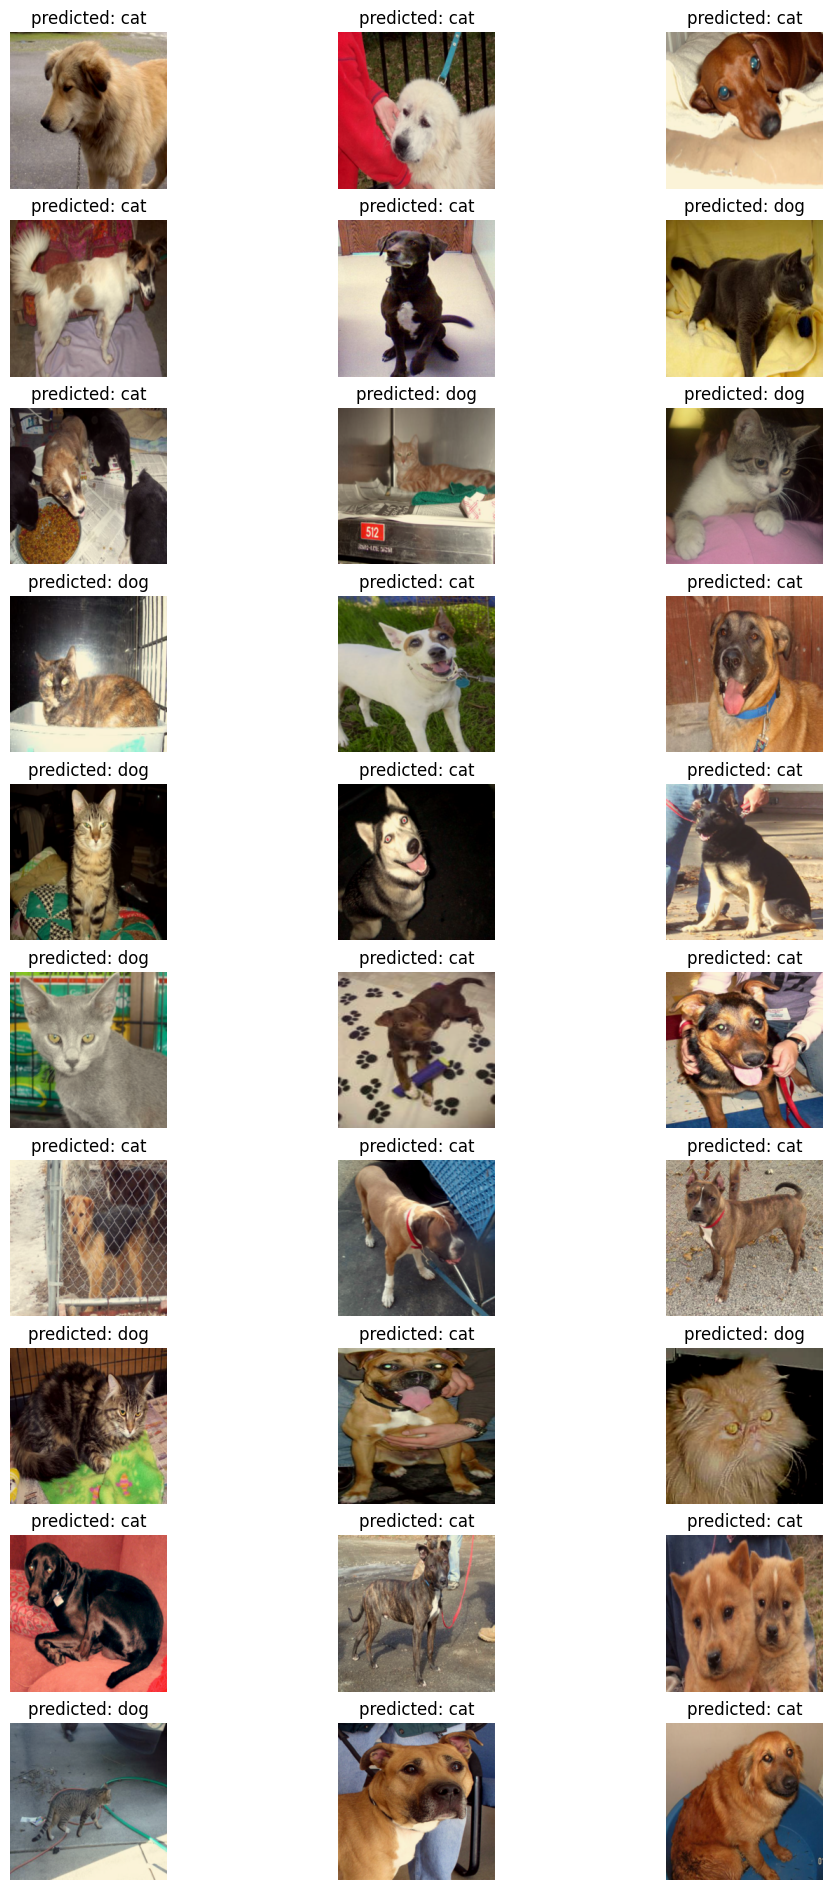

39 images out of 201 were misclassified.


In [52]:
plot_errors(model, valid_dl, device)